In [30]:
import binascii
import numpy as np
import matplotlib.pyplot as plt


import UPVlog

notebook_filename="03b-Receptor Digital"
mylogger=UPVlog.UPVlog(notebook_filename)

# Receptor digital

En este cuaderno veremos cómo recuperar los bits a partir de la señal ruidosa recibida.

* En primer lugar trabajaremos sabiendo en qué instantes están los bits

* Luego haremos un detector de sincronismo

## Receptor simple

El receptor más simple consiste en *muestrear* **en los centros de los pulsos** y depediendo de si la señal es positiva o negativa decidir uno o cero.

Empezaremos por la señal muestrasr que sabemos en qué instantes está el centro de los pulsos

<center>
<img title="Receptor digital simple" alt="Receptor simple" src="images/receptor_simple.png" width=400  align="center">
</center>

La siguiente figura ilustra como se va muestreando el centro de cada nuevo bloque de muestras correspondiente a un nuevo bit

<center>
<img title="Muestreo centro" alt="muestreo centro" src="images/muestreo.gif" width=500  align="center">
</center>
_____________________________

Comenzaremos cargando:

* los bits que se transmitieron

* las muestras de la señal que se recibió, a partir de la cual pretendemos recuperar los bits.

(30600,)


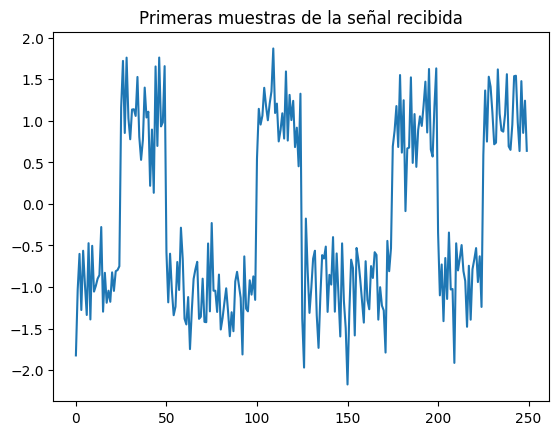

In [31]:
# Carga de los bits que se transmitieron y las muestras recibidas
# Ejecutar esta celda

bits=np.load('bits.npy')
# Carga de las muestras ruidosas. El primer bit corresponde 0-24, 25-49,...
muestrasr=np.load('muestrasr.npy')
print(muestrasr.shape)

# Visualización de la señal recibida
_=plt.plot(muestrasr[:250])
_=plt.title("Primeras muestras de la señal recibida")

En este cuaderno supondremos conocido:

* La cantidad de muestras *D* por bit

* El alineamiento de los bits. Es decir,

  *  El primer bit comprende las muestras desde la 0 (inclusive) hasta la D (exclusive), cuya muestra central es *D//2*
 
  *  El segundo bit comprende las muestras desde la D (inclusive) hasta la 2D (exclusive), cuya muestra central es *D + D//2*
 
  *  ....
 
Con la anterior información el receptor simple a implementar muestreará en **la muestra central correspondiente a cada bit**

In [34]:
# Implementación del receptor simple

mylogger.log("Programando receptorSimple()")

def receptorSimple(muestras_recibidas,D):
    '''
    muestras_recibidas : muestras de la señal recibida (con ruido)
    D: número de muestras correspondientes a cada bit

      *  El primer bit comprende las muestras desde la 0 (inclusive) hasta la D (exclusive). El centro está en D//2
      *  El segundo bit comprende las muestras desde la D (inclusive) hasta la 2D (exclusive). El centro está en D + D//2
      * ...

    La función debe devolver:
       las amplitudes en los centros los pulsos de cada bit
       los instantes a los que corresponden
    '''


    amplitudes = []
    instantes = []
    
    ### BEGIN SOLUTION
    n1=0
    n2=n1+D
    while n2 <= len(muestras_recibidas):
        instante=int((n1+n2)//2)
        amps=muestras_recibidas[instante]
        instantes.append(instante)
        amplitudes.append(amps)
        
        n1+=D
        n2+=D
      ### END SOLUTION
    
    return np.array(amplitudes),np.array(instantes)



(1224,) (1224,)


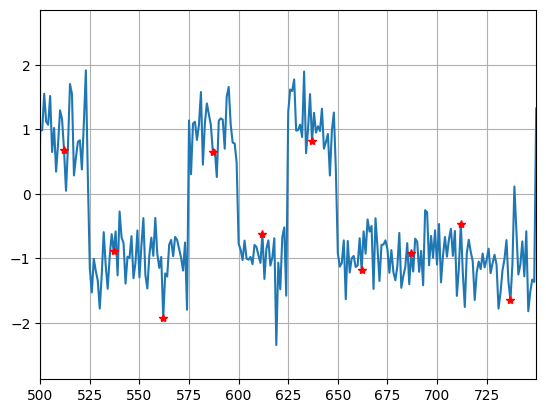

In [35]:
# Comprobación. Debe ver que la celda no de errores y la gráfica tiene sentido

mylogger.log("Testing receptorSimple()")
D= 25
amplitudes, instantes = receptorSimple(muestrasr, D)
print(amplitudes.shape, instantes.shape)

### BEGIN TESTS
assert amplitudes is not None and instantes is not None, "No se ha rellenado la función receptorSimple()"
assert len(amplitudes) == len(instantes), "Las longitudes no coinciden"
assert len(amplitudes) == len(bits), "Las longitudes no coinciden"
assert instantes[0] == D//2, "Los instantes no son correctos"
### END TESTS

# Verificación de que está muestreando en los centros de los pulsos
_=plt.plot(muestrasr)
_=plt.plot(instantes,amplitudes,'*r')
_=plt.xlim(20*D,30*D)
_=plt.xticks(np.arange(20*D,30*D,D))
_=plt.grid()

### BEGIN HIDDEN TESTS
tt=np.arange(D//2,len(muestrasr),D)
assert np.all(instantes==tt), "Los instantes no son correctos"
# AUTOTEST receptorSimple(muestrasr, D)
# AUTOTEST receptorSimple(muestrasr, 3*D)
### END HIDDEN TESTS

mylogger.log("Success Testing receptorSimple()")


A partir de  las amplitudes recibidas es posible determinar los bits que se transmitieron simplemente comparando con un umbral:

* Si la amplitud es >0 ---> 1

* Si la amplitud es < 0 --->0

Complete el código para estimar los bits recibidos

In [16]:
# Commpletar para estimar los bits_recibidos

D=25
bits_recibidos = None # Deben ser de tipo float32
amplitudes,_ = receptorSimple(muestrasr,D)
### BEGIN SOLUTION
bits_recibidos=(amplitudes>0).astype(np.float32)
### END SOLUTION


# Los 3 tamaños deben coincidir
print(len(bits),len(amplitudes),len(bits_recibidos))

1224 1224 1224


In [17]:
# Celda de comprobaciones
# Debe ejecutarla y comprobar que no da errores

# Contiene TESTS ocultos adicionales para la evaluación
mylogger.log("Testing Amplitudes a bits")
### BEGIN TESTS
assert bits_recibidos is not None, "No se ha rellenado bits_recibidos"

assert type(bits_recibidos)==np.ndarray, "bits_recibidos no es un array de numpy"
assert len(bits_recibidos)==len(amplitudes), "bits_recibidos no tiene el tamaño correcto"
assert bits_recibidos.dtype == np.float32, "bits_recibidos no es del tipo correcto. Debe ser float32"

# Todo son 1s y 0s
num_unos = np.sum(bits_recibidos == 1.0)
num_ceros = np.sum(bits_recibidos == 0.0)
assert num_ceros + num_unos == len(amplitudes), "Hay valores distintos de 1 y 0"

bits_recibidos[839:879]
### END TESTS


### BEGIN HIDDEN TESTS
ref=np.array([0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0.])
assert np.all(bits_recibidos[839:879] == ref), "Los valores de los bits no son correctos"
### END HIDDEN TESTS

mylogger.log("Success Testing Amplitudes a bits")

### Medida de la probabilidad de error

Es posible medir la probabilidad de error. Para ello:

* Se cuentan la cantidad de bits erroneos

* Se divide por el total de bits

Complete los valores en la celda de abajo

In [30]:
# completar los valores que valen None
num_bits_erroneos = None
prob_error = None

### BEGIN SOLUTION
num_bits_erroneos = np.sum(bits_recibidos != bits)
prob_error = np.mean(bits_recibidos != bits)
### END SOLUTION




In [31]:
# Comprobaciones del cálculo

mylogger.log("Testing Estima Prob Error")
### BEGIN TESTS
assert num_bits_erroneos is not None and prob_error is not None, "No se han calculado"
assert num_bits_erroneos >0 and num_bits_erroneos < 10, "La cantidad de bits erróneos no es correcta"
### END TESTS

### BEGIN HIDDDEN TESTS
assert num_bits_erroneos ==6, "La cantidad de bits erróneos no es correcta"
assert prob_error > 0.0048 and prob_error < 0.0050, "La prob error no es correcta"
### END  HIDDDEN TESTS

print('Num bits erroneos :' , num_bits_erroneos)
print(f'Probabilidad de error: {prob_error:.5f}')
mylogger.log("Success Testing Estima Prob Error")

Num bits erroneos : 6
Probabilidad de error: 0.00490


Como se ha podido comprobar, el receptor simple produce una cierta cantidad de errores.

Para entender porqué se producen errores veremos los histogramas de las amplitudes que hemos tomado en los centros de los pulsos:

### Histogramas de las amplitudes

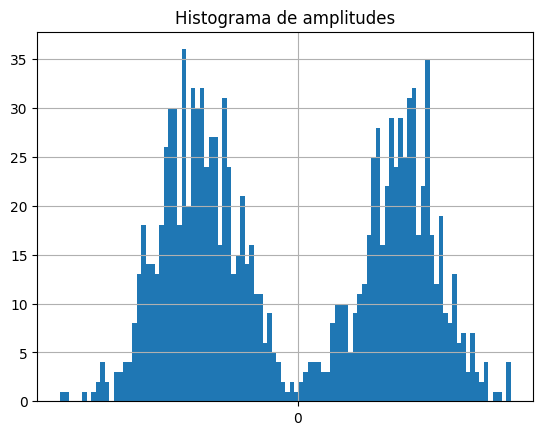

In [32]:
# Representación del histograma
_=plt.hist(amplitudes,100)
_=plt.title('Histograma de amplitudes')
_=plt.xticks([0])
_=plt.grid()

Observamos que hay valores próximos a cero. 

Estos valores son los que pueden dar lugar a errores.

Para comprobar que efectivamente el problema está ahí, vamos a calcular el **histograma de amplitudes de los pulsos correspondientes a haber transimitido un "1", y a haber transmitido un "0" por separado

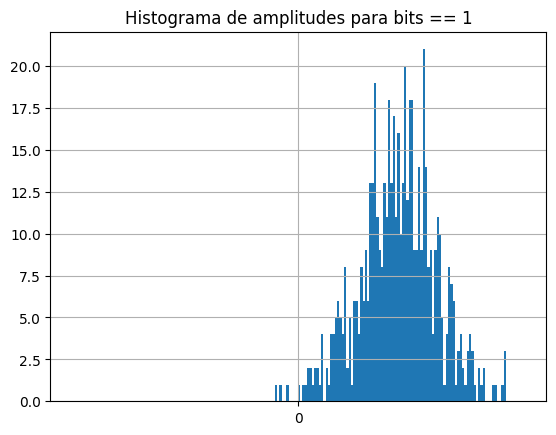

In [33]:
_=plt.hist(amplitudes[bits>0.5],100)
_=plt.xlim(-2.5,2.5)
_=plt.title('Histograma de amplitudes para bits == 1')
_=plt.xticks([0])
_=plt.grid()

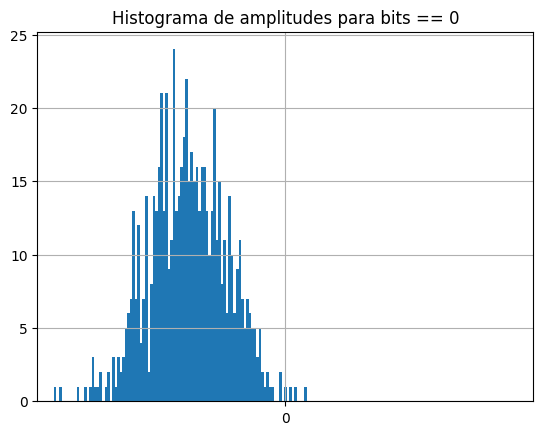

In [34]:
_=plt.hist(amplitudes[bits<0.5],100)
_=plt.xlim(-2.5,2.5)
_=plt.title('Histograma de amplitudes para bits == 0')
_=plt.xticks([0])
_=plt.grid()

Puede observarse claramente en los anteriores histogramas que en algunos casos en que la amplitud transmitida fue "1", la amplitud recibida fue < 0.

En la siguiente gráfica se muestra el aspecto de la señal recibida en un pulso que se transmitió como "1", pero la amplitud recibida fue < 0, o lo que es lo mismo los bits que se transmitió un "1" y se *confundió" un "0".


[ 615 1092 1178]


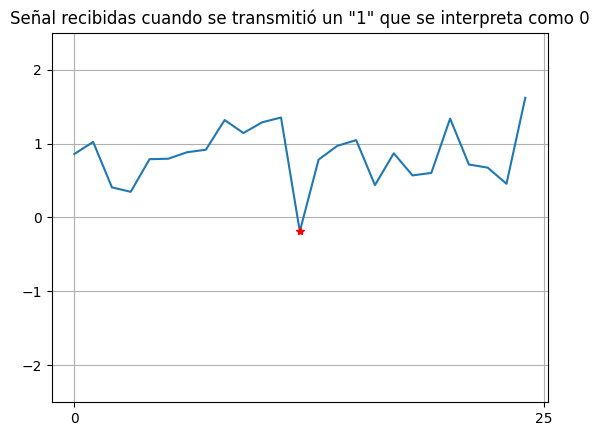

In [35]:
# Encontramos los bits que se transmitieron
inst_falsos_ceros=np.squeeze(np.argwhere((bits==1 )*(bits_recibidos==0)))
print(inst_falsos_ceros)

# Representamos la señal del primer error
for n in inst_falsos_ceros[:1]:
    _=plt.plot(muestrasr[n*D:(n+1)*D])
    _=plt.plot(D//2, muestrasr[n*D+D//2],'*r')
    _=plt.title('Señal recibidas cuando se transmitió un "1" que se interpreta como 0')
_=plt.xticks([0,25])
_=plt.ylim(-2.5,2.5)
_=plt.grid()

Podemos observar cómo 

* La mayoría de las muestras están próximas a 1

* Hemos tenido la mala suerte de mirar en la única muestra que es negativa

_____________________________________________

## Receptor que calcula la media en cada símbolo

Una manera de mejorar el receptor consiste en vez de tomar una muestra en el centro de cada pulso, en calcular  **la media de las D muestras**

Como antes supondremos que:

* La cantidad de muestras  por bit es *D*

* El alineamiento de los bits. Es decir,

  *  El primer bit comprende las muestras desde la 0 (inclusive) hasta la D (exclusive)
 
  *  El segundo bit comprende las muestras desde la D (inclusive) hasta la 2D (exclusive)
 
  *  ....
 
En el receptor iremos calculando la media de las muestras recibidas correspondientes a cada 0/1. La siguiente figura ilustra cómo cada vez que llegan las *D* muestras de un nuevo bit se calcula la media


<center>
    
    Medias de las muestras de cada símbolo
    
<img title="Promedio" alt="Promedio" src="images/blockmean.gif" width=500  align="center">


</center>

Es interesante obervar que los valores de las medias están más próximos a 1 que cuando simplemente muestreábamos en el centro del símbolo

<center>
    
    Muestreo en el centro del símbolo
    
<img title="Muestreo centro" alt="muestreo centro" src="images/muestreo.gif" width=500  align="center">


</center>

In [26]:
def receptorMedia(muestras_recibidas,D):
    '''
    muestras_recibidas: muestras ruidosas transmitidas
    D: cantidad de muestras por cada bit

      *  El primer bit comprende las muestras desde la 0 (inclusive) hasta la D (exclusive)
      *  El segundo bit comprende las muestras desde la D (inclusive) hasta la 2D (exclusive)
      *  ....

    Debe devolver un array de numpy conteniendo la media de las muestras_recibidas correspondientes a cada bit
    El tamaño de la salida debe coincidir con len(muestras_recibidas)//D 
    '''
    amplitudes=None
    ### BEGIN SOLUTION
    amplitudes=[]
    n1=0
    n2=n1+D
    lenx=len(muestras_recibidas)
    while n2 <= lenx:
        media_simbolo=np.mean(muestras_recibidas[n1:n2])
        amplitudes.append(media_simbolo)
        n1 += D
        n2 += D
    amplitudes =np.array(amplitudes)
    ### END SOLUTION
    
    return amplitudes

#NOTA: si no convertimos a float32 da error. 
#Habría que ponerlo en el enunciado

In [27]:
# Comprobación del funcionamiento
# Comprobar que no da errores, para que la celda se corrija como correcta

bits=np.load('bits.npy')
# Carga de las muestras ruidosas. El primer bit corresponde 0-24, 25-49,...
muestrasr=np.load('muestrasr.npy')

amplt_recibidas2=receptorMedia(muestrasr,D)
print(len(amplt_recibidas2),len(bits))
# la longitud de amplt_recibidas2 debe coincidir con el número de bits
mylogger.log("Testing receptor Media")
### BEGIN TESTS
assert amplt_recibidas2 is not None,"Función receptorMedia() no completada"
assert type(amplt_recibidas2)==np.ndarray, "La función debe devolver un array de nympy"
assert np.all(np.isclose(amplt_recibidas2[100::400],np.array([-0.9763659 , -0.84768724, -0.9103348 ], dtype=np.float32)))
### END TESTS

### BEGIN HIDDEN TESTS
# AUTOTEST receptorMedia(muestrasr[25:-25],D)
### END HIDDEN TESTS

mylogger.log("Success Testing receptor Media")

1224 1224


A partir de las amplitudes medias, es posible determinar si era un "1" o un "0" simplemente viendo si el valor es mayor o menor que cero.

In [28]:
# completar los valores que valen None


# Los bits simplemente se obtienen comparando con un umbral
bits_recibidos2=(amplt_recibidas2>0)


num_bits_erroneos_receptor_media = None
prob_error_receptor_media = None

### BEGIN SOLUTION
num_bits_erroneos_receptor_media = np.sum(bits_recibidos2 != bits)
prob_error_receptor_media = np.mean(bits_recibidos2 != bits)
### END SOLUTION

print('Num bits erroneos :' , num_bits_erroneos_receptor_media)
print(f'Probabilidad de error: {prob_error_receptor_media:.5f}')



Num bits erroneos : 0
Probabilidad de error: 0.00000


In [29]:
# Comprobación
mylogger.log("Testing calculo prob error receptor Media")
### BEGIN TESTS
assert num_bits_erroneos_receptor_media is not None and prob_error_receptor_media is not None, "No se ha rellenado los valores"
assert num_bits_erroneos_receptor_media < 2
### END TESTS
### BEGIN HIDDEN TESTS
assert num_bits_erroneos_receptor_media ==0, "num bits_erroneo incorrecto"
### END HIDDEN TESTS
mylogger.log("Success Testing calculo prob error receptor Media")


Para entender lo que ha pasado, visualicemos ahora los histogramas las amplitudes del receptor de media

### Histograma de las amplitudes del receptor de media

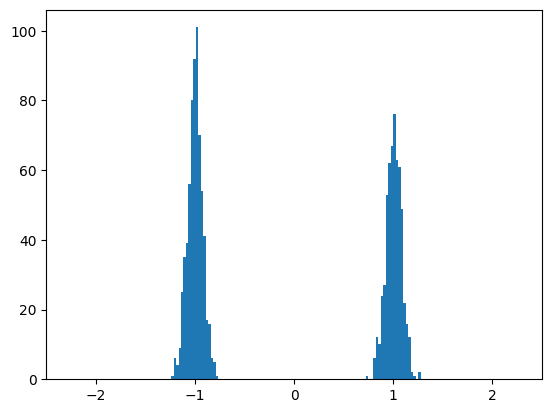

In [23]:
# Histograma de amplitudes recibibidas
_=plt.hist(amplt_recibidas2,bins=100)
_=plt.xlim(-2.5,2.5)

Observamos que:

* No existen valores próximos a "0" que es el umbral para decidir 0/1

* Se distinguen claramente mayores las amplitudes cuando se transimte la amplitud 1 y -1